In [95]:
import sys
import json
from os import listdir
from itertools import product
import importlib
import matplotlib.pyplot as plt
import numpy as np

import input_output
importlib.reload(input_output)
import inheritance_states
importlib.reload(inheritance_states)
import transition_matrices
importlib.reload(transition_matrices)
import genotypes
importlib.reload(genotypes)
import losses
importlib.reload(losses)
import viterbi
importlib.reload(viterbi)

<module 'viterbi' from '/Users/kelley/Projects/PhasingFamilies/phase/viterbi.py'>

In [111]:
# Read in command line arguments
chrom = '5'

data_dir = '../../DATA/ihart/genotypes'
param_file = '../params/ihart_multiloss_params.json'
num_loss_regions = 2
assembly = '37'
detect_deletions = False
ped_file = '../../DATA/ihart/ihart.ped'

#data_dir = '../split_gen_spark'
#ped_file = '../data/spark.ped'
#param_file = '../parameter_estimation/params/spark_multiloss_params.json'
#num_loss_regions = 1
#assembly = '38'
#detect_deletions = True

# set up filenames
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

with open(param_file, 'r') as f: 
    params = json.load(f)

In [112]:
num_samples = 0
with open(sample_file, 'r') as f:
    for line in f:
        num_samples += 1
af_boundaries = np.arange(np.log10(2), np.log10(2000), np.log10(2)).tolist()
af_boundaries.extend([-np.log10(1-10.0**-x) for x in af_boundaries])
af_boundaries = np.array(sorted(af_boundaries))
print(af_boundaries)


[4.24322928e-04 8.49060841e-04 1.69978488e-03 3.40624869e-03
 6.83942453e-03 1.37882845e-02 2.80287236e-02 5.79919470e-02
 1.24938737e-01 3.01029996e-01 3.01029996e-01 6.02059991e-01
 9.03089987e-01 1.20411998e+00 1.50514998e+00 1.80617997e+00
 2.10720997e+00 2.40823997e+00 2.70926996e+00 3.01029996e+00]


In [113]:
# pull families of interest
families = input_output.pull_families(ped_file)

families pulled 1002


In [158]:
import random


family = random.choice(families)
#family = [f for f in families if f.id=='AU1820'][0]
print('family', family.id, family.individuals)

family AU1919 ['AU1919202', 'AU1919201', 'AU1919301', 'AU1919302']


In [159]:
importlib.reload(inheritance_states)
importlib.reload(transition_matrices)

# create inheritance states
if chrom == 'X':
    states = inheritance_states.InheritanceStates(family, detect_deletions, True, num_loss_regions)
else:
    states = inheritance_states.InheritanceStates(family, detect_deletions, detect_deletions, num_loss_regions)

# create transition matrix
transitions = transition_matrices.TransitionMatrix(states, params)
                

fixed [('AU1919301', 'mat'), ('AU1919301', 'pat')]
inheritance states (8, 9)
transitions (8, 4)


In [177]:
importlib.reload(losses)

# create loss function
loss = losses.LazyLoss(states, family, params, num_loss_regions, af_boundaries)


no data set()
AU1919202	0/0		0/1		1/1		./.
0/0	0.00-0.00	3.83-2.82	5.41-4.57	3.47-2.46
0/1	2.42-1.72	0.00-0.02	2.87-2.08	3.41-2.05
1/1	4.31-3.92	3.62-2.04	0.00-0.01	3.34-2.54
-/0	0.00-0.00	3.83-2.82	5.41-4.57	3.47-2.46
-/1	4.31-3.92	3.62-2.04	0.00-0.01	3.34-2.54
-/-	3.62-2.04	4.86-4.25	3.83-2.82	0.00-0.00
AU1919201	0/0		0/1		1/1		./.
0/0	0.00-0.00	3.83-2.82	5.00-4.84	3.38-2.41
0/1	2.34-1.66	0.00-0.02	3.16-1.97	3.14-2.00
1/1	5.22-3.93	3.62-2.04	0.00-0.01	3.23-2.62
-/0	0.00-0.00	3.83-2.82	5.00-4.84	3.38-2.41
-/1	5.22-3.93	3.62-2.04	0.00-0.01	3.23-2.62
-/-	3.62-2.04	5.11-4.38	3.83-2.82	0.00-0.00
AU1919301	0/0		0/1		1/1		./.
0/0	0.00-0.00	3.81-2.80	5.78-4.43	3.52-2.50
0/1	3.17-2.52	0.00-0.00	5.59-3.23	3.57-2.33
1/1	4.97-3.49	3.61-2.05	0.00-0.01	3.29-2.55
-/0	0.00-0.00	3.81-2.80	5.78-4.43	3.52-2.50
-/1	4.97-3.49	3.61-2.05	0.00-0.01	3.29-2.55
-/-	3.61-2.05	5.37-3.96	3.81-2.80	0.00-0.00
AU1919302	0/0		0/1		1/1		./.
0/0	0.00-0.00	3.86-2.84	5.78-4.61	3.69-2.57
0/1	2.79-2.48	0.00-0.00	4.80-2.79	

In [182]:
import input_output
importlib.reload(input_output)

# pull genotype data for this family
family_genotypes, family_snp_positions, mult_factor = input_output.pull_gen_data_for_individuals(data_dir, af_boundaries, assembly, chrom, family.individuals)
print('Data pulled')



(4, 4522196) (4522196,)
genotypes pulled (5, 575085) [[ 0 -1  0 ...  0  1  0]
 [ 0  2  0 ...  0  0  0]
 [ 0 -1  0 ...  0  1  0]
 [ 0 -1  0 ...  0  0  0]
 [ 0 16  0 ...  0 12  0]]
Data pulled


In [183]:
loss.set_cache(family_genotypes)


(410, 5)
[[-1  1  1  2  9]
 [-1  1  2  0 11]
 [-1  2  0  2 11]
 ...
 [ 2  2  2  2  8]
 [ 2  2  2  2  9]
 [ 0  0  0  0  0]]
cached losses (8, 411) already_calculated 251


In [184]:
loss(np.zeros((len(family)+1,), dtype=int))

array([0.00069839, 0.00780699, 0.00069839, 0.00780699, 0.00069839,
       0.00780699, 0.00069839, 0.00780699])

In [185]:
loss(np.ones((len(family)+1,), dtype=int))

[1 1 1 1 1] [5.07453319 4.39687324 6.32906585 4.76858517 6.32925203 4.77144591
 5.12537609 5.12454606]


array([5.07453319, 4.39687324, 6.32906585, 4.76858517, 6.32925203,
       4.77144591, 5.12537609, 5.12454606])

In [186]:
# forward sweep
v_cost = viterbi.viterbi_forward_sweep(family_genotypes, family_snp_positions, mult_factor, states, transitions, loss)




[-1  2 -1 -1 16] [14.30283428 10.52007816 14.30315786 10.53168197 14.30690818 10.52121083
 14.3070173  10.53133717]
[-1 -1  2 -1 16] [13.66156521 10.15584298 13.87889862 10.10348298 13.87734813 10.1035597
 13.85187456 10.22300508]
[-1  1  0  0 16] [5.29132997 4.25407599 7.23099892 5.27201743 5.29929358 4.27144056
 7.23893602 5.28929643]
[1 2 0 2 9] [6.1739885  4.70256073 6.15543057 4.6458415  4.37597659 3.74363296
 4.07066764 3.08812132]
[ 2  0  1 -1 11] [4.92405495 3.64426849 4.92275249 3.64543148 4.92400896 3.6451967
 4.92271054 3.64630297]
[ 2  2  2 -1  7] [3.73269971 2.74613692 3.73271687 2.74604244 3.73273313 2.74606326
 3.73275029 2.74596914]
[ 2  1 -1  0  8] [7.21012346 5.59871044 7.00014845 5.62638047 7.2214622  5.53215927
 6.95396381 5.73309884]
[-1 -1 -1  2  4] [9.8782929  7.69211361 9.88221211 7.67498332 9.8810396  7.67925177
 9.88492314 7.66398686]
[-1  0  1  0 15] [7.17856121 5.22277923 6.95464131 5.08191413 4.95140244 3.59554273
 4.94979481 3.5922306 ]
[-1  0  2  0 11] [1

[-1  2  2  2  2] [3.34425506 2.55552981 3.34425624 2.55554838 3.34570891 2.56072122
 3.34571009 2.56073979]
[-1  2  2  2 14] [7.01020039 5.63148492 7.01468504 5.69724318 8.15080385 7.26204703
 8.15528831 7.32762815]
[-1  2  2  2  3] [3.34961932 2.55715523 3.34962168 2.55719251 3.35253355 2.5675166
 3.35253592 2.56755388]
[ 2  0  0  0 11] [4.07176671 3.2736991  4.07372542 3.28314071 6.2933831  5.24487374
 6.29532084 5.25369896]
[1 0 0 0 8] [1.92815653 1.92483634 1.9340064  1.95256433 4.55657885 4.08667603
 4.56233302 4.11229218]
[-1  2  0  0  8] [ 7.90739726  5.4209176   9.83382482  7.43844485  8.55744086  6.34101789
 10.45998423  8.1179784 ]
[-1  0  1  0 12] [6.93264973 5.17464277 6.46985998 4.67148621 4.38252917 3.03027434
 4.38150621 3.02973862]
[ 1  1 -1  1 12] [4.72952178 3.51683669 4.55110144 3.70470983 4.55110143 3.704716
 4.72948217 3.51788058]
[ 1  2  2  2 12] [1.93346097 1.94790631 1.93436161 1.96188267 5.93604785 4.22067092
 5.93691809 4.23449004]
[ 1  1  0  0 13] [1.92660202

[ 2  0 -1 -1 11] [8.48794265 5.96386464 8.48908669 5.96431683 8.48794974 5.96415676
 8.48909183 5.96458847]
[ 0  1  2  2 11] [3.62523828 2.95146091 7.20768442 4.88803395 5.51629742 5.02026372
 8.8005545  6.74504512]
[ 2  0  0  0 11] [4.07176671 3.2736991  4.07372542 3.28314071 6.2933831  5.24487374
 6.29532084 5.25369896]
[ 0  2  2  2 11] [3.62274956 2.9372257  3.62304999 2.94193485 5.51380873 5.00603457
 5.51410907 5.01070895]
[1 0 2 2 9] [3.5504084  2.8815619  6.41742049 5.00510568 7.13303096 4.82053912
 8.98105391 6.71072734]
[2 0 2 2 8] [3.31980647 2.64198394 5.71479083 4.39041528 3.32000152 2.64321234
 5.71498572 4.39163959]
[-1  1  2  2 11] [4.27685514 3.15763191 7.85931469 5.09434842 4.54521242 3.76463048
 8.12293788 5.69467645]
[ 0  0  1  1 14] [3.37023211 2.68477599 3.71263596 3.01922632 3.63309055 2.95241423
 6.34938144 4.93560333]
[ 1  0  2  2 12] [3.80074436 3.13563199 7.13288928 5.5216128  7.80324195 5.40758295
 9.26695343 7.17758435]
[ 1  0  0 -1 12] [4.66845106 3.5578142

[ 1  1  0  0 17] [4.2104485  4.10243006 5.8955055  4.86739207 5.89566904 4.86978586
 7.54477408 5.62955874]
[ 2 -1  2  2  4] [3.25199019 2.63890953 3.2603572  2.66676173 3.25199949 2.6389681
 3.26036649 2.6668203 ]
[ 1 -1 -1 -1 13] [11.1622358   7.85273114 11.17910293  7.8605342  11.18220021  7.87404861
 11.17784568  7.86552787]
[1 2 1 2 5] [5.12637122 3.45539055 5.09102253 3.44087568 1.54986198 1.57571099
 1.5498716  1.57581894]
[-1 -1  0  1 13] [10.32074925  7.3424098   7.6280331   5.40842332  7.76912206  5.40672253
  7.47111412  5.24347995]
[-1  0  1  0 18] [7.26929838 5.26230541 7.22421992 5.23980422 5.80566832 4.40763542
 5.80405288 4.404484  ]
[-1  0  1  0 20] [7.28100064 5.26736103 7.26890518 5.26155149 6.36317646 4.85731037
 6.3617003  4.85505256]
[2 0 0 1 9] [4.3719324  3.72054262 4.36996582 3.70312955 3.8971284  3.14524417
 3.8990752  3.15432699]
[ 0  0  2  0 18] [5.78242239 4.44405714 5.7824183  4.44350397 5.78241897 4.44358339
 5.78234715 4.44295685]
[-1  1  0  0 12] [4.310

[ 1  1  1  2 15] [6.59752583 4.98816794 3.04352392 3.08178254 3.04352392 3.08178188
 6.73811896 5.34421824]
[0 1 1 0 7] [5.49700694 4.99449591 2.75926671 2.73942685 4.3205002  3.65419726
 2.77054354 2.7926091 ]
[ 1  0 -1  1 16] [5.40106561 4.17750993 5.40103382 4.17762242 5.34898591 4.3435637
 5.34901405 4.34341274]
[-1  0  1  1  9] [4.27153283 3.12197539 4.27516699 3.14099776 4.540029   3.72617291
 4.54007096 3.69203577]
[-1  1 -1  1  8] [7.67132733 5.35849079 7.43580109 5.55109791 7.60109715 5.47094153
 7.48248766 5.42249079]
[ 2 -1 -1 -1 13] [12.26393489  8.874592   12.29482426  8.87978414 12.26426899  8.87650546
 12.294802    8.88023734]
[ 0  2  2  0 11] [8.11867833 6.4178141  8.10184706 6.10129363 6.4166201  5.39560523
 6.26304898 4.77334188]
[0 1 0 1 8] [5.01332995 4.25852554 1.92998894 1.93381816 3.85090762 3.16927483
 1.93486716 1.95744326]
[ 0 -1  1  0  9] [6.84094662 5.39689077 4.3464109  3.20464617 6.38726068 4.69939971
 4.34709691 3.20950007]
[ 0 -1  2  0 13] [9.29185968 6.

[ 1  1  1  2 16] [7.18545916 5.57074725 3.63168789 3.66997604 3.63168789 3.66997607
 7.34372386 5.95739979]
[-1 -1 -1  2 11] [10.45347294  7.59056398 10.58380275  7.40930087 10.55971625  7.41907151
 10.63370048  7.47838092]
[-1  1 -1 -1 14] [11.62001994  8.22880172 11.62967252  8.25088039 11.6275298   8.23355201
 11.62775344  8.24572205]
[ 2  0  1  2 17] [8.95421652 6.70566174 8.44195357 6.662189   8.87552206 6.96972365
 8.50814628 6.97331827]
[ 0  1  1 -1 12] [4.70045606 3.43661051 4.66848423 3.56060943 4.70005248 3.43761832
 4.66885944 3.55928676]
[ 1 -1  1  1 14] [4.58112008 3.59340441 4.6707798  3.72087973 7.84498773 5.66097566
 5.31006449 4.18375957]
[ 1  0 -1  0 14] [4.80827182 3.7917703  4.80828642 3.79147488 4.86005408 3.62946574
 4.85993817 3.62970658]
[1 2 1 1 3] [2.12132368 2.14595041 2.12132848 2.14606806 5.43495919 3.87960028
 5.4254735  3.87796947]
[ 0  1 -1  1 17] [5.69202052 4.47138837 5.63995319 4.63742898 5.69200738 4.47143826
 5.63996479 4.63736788]
[ 0  1  0  2 18] 

[ 0 -1  1  0 12] [6.72345554 5.13253034 4.12056254 2.9825158  6.34841665 4.66960592
 4.12016248 2.98203928]
[1 1 1 2 6] [6.02119412 4.32015545 2.46836688 2.45050051 2.46836619 2.45013578
 4.59594506 3.04940984]
[1 1 1 2 6] [6.02119412 4.32015545 2.46836688 2.45050051 2.46836619 2.45013578
 4.59594506 3.04940984]
[ 2  0  2  1 12] [6.98983907 4.63818791 4.27404653 3.55818851 6.50007302 4.53981644
 4.2757959  3.56904704]
[-1  0  2  0 13] [9.41276394 6.98388348 9.37030968 6.93527634 9.34775319 6.288791
 7.66415591 5.54998268]
[ 0  2  0  1 14] [5.62906819 4.90034751 4.42197776 3.2543433  5.62716813 4.8772465
 4.4220642  3.2548714 ]
[ 1 -1 -1 -1 13] [11.1622358   7.85273114 11.17910293  7.8605342  11.18220021  7.87404861
 11.17784568  7.86552787]
[ 0  2 -1  0 16] [8.21490732 6.25357784 8.24070824 6.09983547 8.2149098  6.2535182
 8.24069819 6.09988028]
[ 0  0 -1  1 14] [6.83243709 4.87756814 6.80951002 4.93607091 6.81326168 4.92718649
 6.79138608 4.99293573]
[ 1  1  0  1 18] [7.63377501 6.806

Forward sweep complete 21.14393711090088 sec


In [187]:
print(v_cost)

[[5.58715254e-03 1.43084217e+01 1.43251835e+01 ... 3.39882757e+05
  3.39886485e+05 3.39886221e+05]
 [6.24559324e-02 1.05825344e+01 1.07699025e+01 ... 3.39889671e+05
  3.39892234e+05 3.39891857e+05]
 [5.58715254e-03 1.43087453e+01 1.43255071e+01 ... 3.39874868e+05
  3.39878331e+05 3.39878332e+05]
 ...
 [6.24559324e-02 1.05836671e+01 1.07710352e+01 ... 3.39895145e+05
  3.39895439e+05 3.39895437e+05]
 [5.58715254e-03 1.43126048e+01 1.43293665e+01 ... 3.39882987e+05
  3.39883967e+05 3.39883969e+05]
 [6.24559324e-02 1.05937934e+01 1.07811615e+01 ... 3.39889901e+05
  3.39890164e+05 3.39890159e+05]]


In [188]:
importlib.reload(viterbi)

# backward sweep
final_states = viterbi.viterbi_backward_sweep(v_cost, states, transitions)


Num solutions (1,) 339878.33214281395 (array([1, 1, 1, 1, 0, 0, 0, 1, 0], dtype=int8),)
(1,)
Num positions in fork 58590
Backward sweep complete 75.564612865448 sec


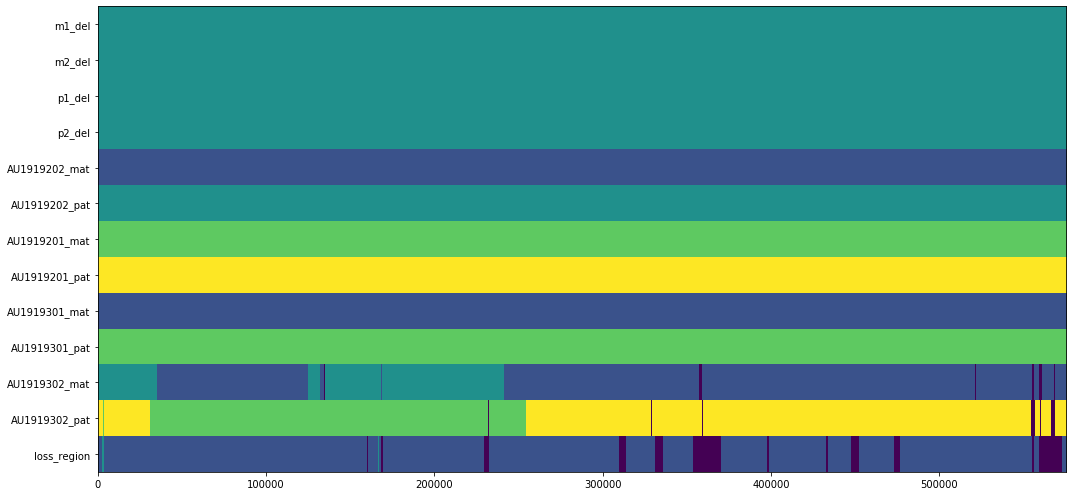

In [189]:
final_states_greyed = final_states.copy()
final_states_greyed[:, final_states[-1, :]!=0] = -1

plt.figure(figsize=(15, 7))
plt.imshow(final_states, aspect='auto', vmin=-1)
plt.yticks(np.arange(final_states.shape[0]), 
           ['m%d_del' % i for i in range(1, 2*len(family.mat_ancestors)+1)] + ['p%d_del' % i for i in range(1, 2*len(family.pat_ancestors)+1)] + \
           sum([['%s_mat' % x,'%s_pat' % x] for x in family.individuals], []) + ['loss_region'])

#plt.subplot(2, 1, 2, sharex=ax)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=0) & (family_snp_positions[:, 1]<=20500000), alpha=0.5)
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 0]>=9600000) & (family_snp_positions[:, 1]<=16300000))
#plt.fill_between(np.arange(family_snp_positions.shape[0]), 0, (family_snp_positions[:, 1]<=9600000) | (family_snp_positions[:, 0]>=48200000))

#plt.xticks(xticks, xlabels, rotation=90)

#plt.subplot(3, 1, 3)
#plt.plot(np.log2(family_snp_positions[:, 1]-family_snp_positions[:, 0]), marker='.', linestyle='')
#plt.plot(c[1:]-c[:-1], marker='.', linestyle='')
#plt.plot(num_non_mend, marker='.', linestyle='')
#plt.plot(np.convolve(num_non_mend, np.ones((100,)), mode='same'))
#plt.plot(np.convolve(num_missing, np.ones((100,)), mode='same'))
#plt.scatter(family_snp_positions[:, 0], final_states[-1, :], marker='.')
#plt.xticks(family_snp_positions[xticks, 0], xlabels, rotation=90)
#for i in np.where(family_snp_positions[:, 1]-family_snp_positions[:, 0] > 10000)[0]:
#    plt.plot([family_snp_positions[i, 0], family_snp_positions[i, 1]], [final_states[-1, i], final_states[-1, i]], color='grey')
#    #print(family_snp_positions[i, :])
plt.tight_layout()
plt.show()

In [199]:
np.sum((final_states[-1, :]==0)*mult_factor)/np.sum(mult_factor)

0.9118052379861465

In [206]:
starts = np.where((final_states[-1, :-1]==0) & (final_states[-1, 1:]==-1))[0]+1
ends = np.where((final_states[-1, :-1]==-1) & (final_states[-1, 1:]==0))[0]+1
print(starts, ends)

[159772 166208 167969 229053 309213 330630 353391 397284 432044 446984
 472367 554310 558352] [160187 166779 169116 231943 313532 335608 370025 398388 433305 451441
 475811 555474 571873]


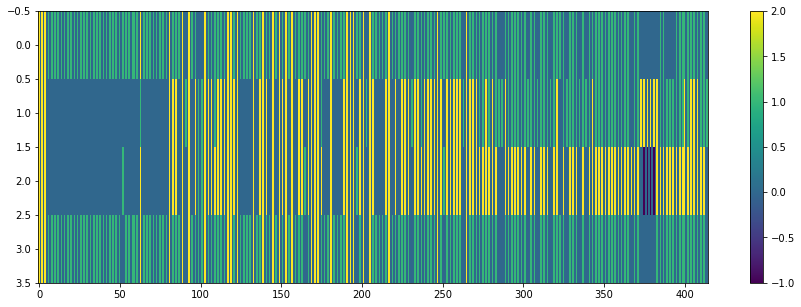

In [212]:
plt.figure(figsize=(15, 5))
plt.imshow(family_genotypes[:-1, starts[0]:ends[0]], aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
np.where(family_genotypes[2, :]!=family_genotypes[3, :])

In [ ]:
sample_id_to_sex = input_output.pull_sex(ped_file)

print([sample_id_to_sex[x] for x in family.individuals])


In [ ]:
#importlib.reload(input_output)
#
#with open('../phased_ihart/chr.%s.%s.phased.txt' % (chrom, family.id), 'w+') as phasef:
#    phasef.write('\t'.join(['family'] + \
#                           ['m%d_del' % i for i in range(1, 2*len(family.mat_ancestors)+1)] + \
#                           ['p%d_del' % i for i in range(1, 2*len(family.pat_ancestors)+1)] + \
#                           sum([['%s_mat' % x, '%s_pat' % x] for x in family.individuals], []) + \
#                           ['loss_region', 'start_pos', 'end_pos']) + '\n')
#    input_output.write_to_file(sys.stdout, phasef, family, final_states, family_snp_positions)




In [ ]:
import ancestral_variants
importlib.reload(ancestral_variants)

ancs = -np.ones((len(family), family_genotypes.shape[1]))
change_indices = [-1] + np.where(np.any(final_states[:, 1:]!=final_states[:, :-1], axis=0))[0].tolist() + [family_snp_positions.shape[0]-1]
for j in range(1, len(change_indices)):
    s_start, s_end = change_indices[j-1]+1, change_indices[j]
    assert np.all(final_states[:, s_start] == final_states[:, s_end])
    if np.all(final_states[:, s_start]>=0):
        state = states.get_original_state(final_states[:, s_start])
        variants = ancestral_variants.AncestralVariants(states, gens, loss, family, state)
        for i in range(s_start, s_end+1):
            ancs[:, i] = variants(tuple(family_genotypes[:, i]))
    
    

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(ancs, aspect='auto')
plt.show()

print(np.unique(ancs, return_counts=True))

In [ ]:
is_hts = final_states[-1, :]==1
has_m1_deletion = final_states[0, :]==0
has_m2_deletion = final_states[1, :]==0
has_p1_deletion = final_states[2, :]==0
has_p2_deletion = final_states[3, :]==0

preferred_phase_options = [[0, -1], [1, -1], [2, -1], [3, -1], [0, -1], [2, -1]] + [[0, 1, -1], [2, 3, -1]]*(m-3)

has_upd = np.zeros((2*m, final_states.shape[1]), dtype=bool)
for i in range(m):
    has_upd[2*i, :] = ~np.isin(final_states[4+2*i, :], preferred_phase_options[2*i])
    has_upd[2*i + 1, :] = ~np.isin(final_states[5+2*i, :], preferred_phase_options[2*i + 1])

print('hard to sequence', np.sum(mult_factor * is_hts)/np.sum(mult_factor))     

print('m1 deletion', np.sum(mult_factor * (has_m1_deletion & ~is_hts)))
print('m2 deletion', np.sum(mult_factor * (has_m2_deletion & ~is_hts)))
print('p1 deletion', np.sum(mult_factor * (has_p1_deletion & ~is_hts)))
print('p2 deletion', np.sum(mult_factor * (has_p2_deletion & ~is_hts)))

# maternal UPD
print('maternal UPD', np.sum(mult_factor * ((has_upd[0, :] | has_upd[1, :]) & ~is_hts)))
print('paternal UPD', np.sum(mult_factor * ((has_upd[2, :] | has_upd[3, :]) & ~is_hts)))

for i in range(m-2):
    print('child%d mat upd' % (i+1), np.sum(mult_factor * (has_upd[4+2*i, :] & ~is_hts)))
    print('child%d pat upd' % (i+1), np.sum(mult_factor * (has_upd[5+2*i, :] & ~is_hts)))


In [ ]:
#event = has_p1_deletion & ~is_hts
event = has_upd[6, :]
del_start = np.where(~event[:-1] & event[1:])[0]+1
del_end = np.where(event[:-1] & ~event[1:])[0]+1

print(len(del_start), len(del_end))
print(del_start, del_end)

# remove events in hard to sequence regions
event_is_hts = np.ones((del_start.shape[0],), dtype=bool)
for i, (s, e) in enumerate(zip(del_start, del_end)):
    event_is_hts[i] = np.any(is_hts[s:e])
print('hard to seq', event_is_hts)
    
#del_start = np.array(del_start)[~event_is_hts]
#del_end = np.array(del_end)[~event_is_hts]
#print(len(del_start), len(del_end))

print(del_start, del_end)

In [ ]:
dstart, dend = random.choice(list(zip(del_start, del_end)))
start, end = max(0, dstart-100), min(dend+100, family_genotypes.shape[1])

print(final_states[:, start])
#print(dstart, dend)
#print(family_snp_positions[dstart, :], family_snp_positions[dend, :])
#start, end = 168156000, 168172000
#start, end = 71706745, 71715561
#start, end = 225044, 225185

#start, end = 3711060, 3711393
#start, end = np.where(family_snp_positions[:, 0]>=start)[0][0], np.where(family_snp_positions[:, 0]<=end)[0][-1]
#start, end = max(0, start-100), min(end+100, family_genotypes.shape[1])

state_indices_of_interest = []

plt.figure(figsize=(15, 10))
ax = plt.subplot(4, 1, 1)
plt.plot(mult_factor[start:end])

plt.subplot(4, 1, 2, sharex=ax)
plt.imshow(family_genotypes[:, start:end], aspect='auto', vmin=-3, vmax=2)
plt.yticks(np.arange(m), ['mom', 'dad'] + ['child %d' % i for i in range(1, m-1)])

plt.subplot(4, 1, 3, sharex=ax)
plt.imshow(final_states[[0, 1, 2, 3] + \
                               [4, 5] + np.arange(8, 4+(2*m), 2).tolist() + \
                               [6, 7] + np.arange(9, 4+(2*m), 2).tolist() + [-1], start:end],
           aspect='auto', vmin=-1, vmax=3)
plt.yticks(np.arange(final_states.shape[0]), 
           ['m1 del', 'm2 del', 'p1 del', 'p2 del', 'm1', 'm2'] + ['child_%d mat' % i for i in range(1, m-1)] + ['p1', 'p2'] + ['child_%d pat' % i for i in range(1, m-1)] + ['is_hts'])

#plt.subplot(4, 1, 4, sharex=ax)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.clip(final_states[:, j], 0, None)))] for j in range(start, end)], alpha=0.5)

#plt.subplot(5, 1, 5, sharex=ax)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.clip(final_states[:, j], 0, None)))] for j in range(start, end)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.hstack((np.clip(final_states[:2*m, j], 0, None), [0,]*(2*(m-2)), [np.clip(final_states[-1, j], 0, None)]))))] for j in range(start, end)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.hstack(([1,]*4, np.clip(final_states[4:, j], 0, None)))))] for j in range(start, end)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0))] for j in range(start, end)], alpha=0.5)
#plt.plot(np.cumsum([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0))] for j in range(start, end)]), alpha=0.5)
#plt.plot(np.cumsum([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0))] for j in range(start, end)]), alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0))] for j in range(start, end+1)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0))] for j in range(start, end+1)], alpha=0.5)



plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 3))
plt.imshow(family_genotypes[:, start:end], aspect='auto', vmin=-3, vmax=2)
plt.show()

In [ ]:
markers = []
labels = []
with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] == chrom:
            markers.append(int(pieces[1]))
            labels.append(chrom + pieces[3])

plt.figure(figsize=(15, 3))
x = sum([[s-1, s, e, e+1] for s, e in zip(family_snp_positions[del_start, 0], family_snp_positions[del_end, 1])], [])
y = sum([[0, 1, 1, 0] for s, e in zip(del_start, del_end)], [])
plt.plot(x, y)
plt.xticks([x for x in markers if x>= plt.xlim()[0] and x<=plt.xlim()[1]], 
           [l for x, l in zip(markers, labels) if x>= plt.xlim()[0] and x<=plt.xlim()[1]], rotation=90)
plt.show()

In [ ]:
print(inds)

In [ ]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(m, 1, 1)

for i in range(4):
    #plt.scatter(family_snp_positions[final_states_greyed[i, :] == -1, 0], np.repeat(3-i, np.sum(final_states_greyed[i, :] == -1)), color='blue', alpha=0.5)
    plt.scatter(family_snp_positions[final_states_greyed[i, :] == 0, 0], np.repeat(3-i, np.sum(final_states_greyed[i, :] == 0)), color='red', alpha=0.5)
plt.title('Deletions')
plt.yticks(range(3, -1, -1), ['m1', 'm2', 'p1', 'p2'])

for i in range(0, m-2):
    plt.subplot(m, 1, i+2, sharex=ax)
    indices = (final_states_greyed[4+(2*i), :] == 0) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(0, np.sum(indices)), color='blue', alpha=0.5)
    indices = (final_states_greyed[4+(2*i), :] == 1) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(0, np.sum(indices)), color='red', alpha=0.5)

    indices = (final_states_greyed[5+(2*i), :] == 0) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(1, np.sum(indices)), color='blue', alpha=0.5)
    indices = (final_states_greyed[5+(2*i), :] == 1) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(1, np.sum(indices)), color='red', alpha=0.5)

    plt.title('Child%d' % (i+1))
    plt.yticks(range(0, 2), ['mat', 'pat'])

plt.subplot(m, 1, m, sharex=ax)
plt.scatter(family_snp_positions[final_states_greyed[-1, :] == -1, 0], np.repeat(0, np.sum(final_states_greyed[-1, :] == -1)), color='blue', alpha=0.5)
plt.scatter(family_snp_positions[final_states_greyed[-1, :] == 1, 0], np.repeat(0, np.sum(final_states_greyed[-1, :] == 1)), color='red', alpha=0.5)
plt.title('Hard to sequence')

plt.tight_layout()
plt.show()



In [ ]:
print(family_snp_positions[start, :], family_snp_positions[end, :])

In [ ]:
import numpy as np
def estimate_parental_variants(final_states, family_genotypes):
    m, n = family_genotypes.shape
    parental_variants, cost, blame = -np.ones((4, n), dtype=np.int8), -np.ones((n,), dtype=int), -np.ones((m, n), dtype=float)
    has_missing = 0
    for i in range(n):
        state, gen = final_states[:, i], tuple(family_genotypes[:, i])
        
        missing_indices = [i for i, x in enumerate(state) if x==-1]
        
        if len(missing_indices) == 0:
            pv, v, b = loss.get_parental_variants(tuple(state), gen)
            parental_variants[:, i] = pv
            cost[i] = v
            blame[:, i] = b
        else:
            has_missing += 1
            all_possible_states = np.tile(state, (pow(2, len(missing_indices)), 1))
            all_possible_states[:, missing_indices] = list(product(*[[0, 1]]*len(missing_indices)))

            min_v = None
            all_pvs, all_bs = [], []
            for s in all_possible_states:
                pv, v, b = loss.get_parental_variants(tuple(s), gen)
                if min_v is None or v < min_v:
                    min_v = v
                    all_pvs, all_bs = [pv], [b]
                elif v == min_v:
                    all_pvs.append(pv)
                    all_bs.append(b)

            all_pvs, all_bs = np.asarray(all_pvs), np.asarray(all_bs)
            parental_variants[np.all(all_pvs==-2, axis=0), i] = -2
            parental_variants[np.all(all_pvs==0, axis=0), i] = 0
            parental_variants[np.all(all_pvs==1, axis=0), i] = 1
            cost[i] = min_v
            
            all_bs = np.sum(all_bs, axis=0)
            if min_v == 0:
                blame[:, i] = 0
            else:
                blame[:, i] = min_v*all_bs/np.sum(all_bs)
            
        if i%10000==0:
            print(i, has_missing)
    return parental_variants, cost, blame

parental_variants, cost, blame = estimate_parental_variants(states, family_genotypes)       

In [ ]:
import time
import numpy as np
from itertools import product

def mask_states(family_genotypes, mult_factor, final_states, inheritance_states, loss, error_rate=0.001, smooth=5000):

	masked_final_states = np.copy(final_states)
	# Now, do masking
	prev_time = time.time()
	m, n = family_genotypes.shape
	p, state_len = inheritance_states.p, inheritance_states.state_len

	fit = -np.ones((n,), dtype=int)
	prev_state = None
	prev_state_indices = None
	for j in range(n): 
		pos_gen = tuple(family_genotypes[:, j])
		current_state = tuple(final_states[:, j])

		if current_state != prev_state:
			prev_state = current_state
			num_unknowns = len([x for x in current_state if x == -1])
			if num_unknowns>0:
				prev_state_indices = []
				for poss_itr in [iter(x) for x in product(*([[0, 1]]*num_unknowns))]:
					poss_state = tuple([x if x != -1 else next(poss_itr) for x in current_state])
					prev_state_indices.append(inheritance_states.index(poss_state))
			else:
				prev_state_indices = [inheritance_states.index(tuple(final_states[:, j]))]

		fit[j] = mult_factor[j]*(np.min(loss(pos_gen)[prev_state_indices])==1)
        
	print(np.unique(fit, return_counts=True))


	c = np.convolve(fit/m, np.ones(smooth,), mode='same')
	masked = (c>(error_rate*smooth)).astype(np.int8)
	print('Percent masked', 100*np.sum(masked)/n)

	# if a parental chromosome isn't inherited, then we don't know if it has a deletion
	maternal_indices = range(4, state_len, 2)
	paternal_indices = range(5, state_len, 2)

	m1_ninh = np.all(final_states[maternal_indices, :]!=0, axis=0)
	m2_ninh = np.all(final_states[maternal_indices, :]!=1, axis=0)
	p1_ninh = np.all(final_states[paternal_indices, :]!=0, axis=0)
	p2_ninh = np.all(final_states[paternal_indices, :]!=1, axis=0)

	masked_final_states[0, m1_ninh] = -1
	masked_final_states[1, m2_ninh] = -1
	masked_final_states[2, p1_ninh] = -1
	masked_final_states[3, p2_ninh] = -1
	masked_final_states = np.append(masked_final_states, masked[np.newaxis, :], axis=0)
	print('Percent never inherited', 100*np.sum(m1_ninh)/n, 100*np.sum(m2_ninh)/n, 100*np.sum(p1_ninh)/n, 100*np.sum(p2_ninh)/n)

	print('Masking complete', time.time()-prev_time, 'sec') 
	return masked_final_states, c

In [ ]:
# mask messy areas
masked_final_states, f = mask_states(family_genotypes, mult_factor, final_states, inheritance_states, loss, error_rate=0.01)
#masked_final_states[:, masked_final_states[-1, :]==1] = -1

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(f/1000)
plt.plot(overall)
plt.show()

In [ ]:
smooth=5000
c = np.convolve(np.sum(parental_variants==-2, axis=0), np.ones(smooth,), mode='same')/(smooth*m)
d = np.convolve(np.sum(parental_variants==-1, axis=0), np.ones(smooth,), mode='same')/(smooth*m)

plt.figure(figsize=(15, 5))
plt.plot(a, label='deletion')
plt.plot(b, label='unknown')
plt.plot(c, label='deletion')
plt.plot(d, label='unknown')
#plt.plot(overall)
#plt.ylim([0, 0.1])
plt.axhline(0.01)
plt.legend()
plt.show()

In [ ]:
print(np.sum(parental_variants==-1)/(4*parental_variants.shape[1]))

In [ ]:
print(np.sum(blame==0)/(blame.shape[0]*blame.shape[1]))
print(np.sum(parental_variants==0)/(parental_variants.shape[0]*parental_variants.shape[1]))


In [ ]:
pos_lens = family_snp_positions[:, 1]-family_snp_positions[:, 0]
print(pos_lens.shape)
print(np.sum(parental_variants!=0))
print(np.sum(mult_factor*np.sum(parental_variants!=0, axis=0)))
print(np.sum(mult_factor[np.any(parental_variants!=0, axis=0)]))

In [ ]:
import scipy.sparse as sparse

chrom_length = chrom_lengths[chrom]
nonzeros = np.sum(mult_factor*np.sum(parental_variants!=0, axis=0))
data = np.zeros((nonzeros,), dtype=np.int8)
row_ind = np.zeros((nonzeros,), dtype=int)
col_ind = np.zeros((nonzeros,), dtype=int)

data_index = 0
for i, j in zip(*np.nonzero(parental_variants)):
    pos_start, pos_end = family_snp_positions[j, :]
    pos_length = pos_end - pos_start
    
    data[data_index:(data_index+pos_length)] = parental_variants[i, j]
    row_ind[data_index:(data_index+pos_length)] = i
    col_ind[data_index:(data_index+pos_length)] = range(pos_start, pos_end)
    data_index += pos_length

parental_variants_csc = sparse.csc_matrix((data, (row_ind, col_ind)), shape=(4, chrom_length))

In [ ]:
print(np.nonzero(parental_variants)[0].shape)
print(data[:5])
print(parental_variants_csc.nnz)

In [ ]:
import random
j = random.choice(np.where(mult_factor*np.any(parental_variants!=0, axis=0)>1)[0])
print(j, family_snp_positions[j, :])
print(parental_variants[:, j])
print(parental_variants_csc[:, family_snp_positions[j, 0]:family_snp_positions[j, 1]])

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow((parental_variants==-1)[:1000], aspect='auto')
plt.show()

In [ ]:
smooth=5000
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

ax1 = plt.subplot(2, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
plt.plot(overall, label='overall', color='black')
plt.axhline(0.01, color='black')
plt.legend()
plt.ylim([0, 0.1])

all_convolve = np.vstack((mo, d, c1, c2, c3))

plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(np.vstack((masked_final_states[-1, :], np.sum(all_convolve>0.01, axis=0)>1)), aspect='auto')

plt.show()

In [ ]:

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(3, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.subplot(3, 1, 3, sharex=ax1)
plt.imshow(masked_final_states, aspect='auto')

plt.show()

In [ ]:
smooth=5000
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(3, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.subplot(3, 1, 3, sharex=ax1)
plt.imshow(masked_final_states, aspect='auto')

plt.show()

In [ ]:
m = 5
smooth = 5000

In [ ]:
# family-wise unphased mendelian
unique_gens, indices = np.unique(family_genotypes, axis=1, return_inverse=True)

parents_to_children_with_del = {
    (-1, -1): [-1],
    (-1, 0): [-1, 0],
    (-1, 1): [0, 2],
    (-1, 2): [-1, 2],
    (0, 0): [-1, 0],
    (0, 1): [0, 1, 2],
    (0, 2): [-1, 0, 1, 2],
    (1, 1): [0, 1, 2],
    (1, 2): [0, 1, 2],
    (2, 2): [-1, 2]
    
}

parents_to_children_without_del = {
    (0, 0): [0],
    (0, 1): [0, 1],
    (0, 2): [1],
    (1, 1): [0, 1, 2],
    (1, 2): [1, 2],
    (2, 2): [2]
    
}
parental_genotypes = list(product(*[[0, 1, 2]]*2))

# without del
trio_perfect_match_gens_nodel = set()
trios_could_be_mendelian = np.zeros((family_genotypes.shape[1],), dtype=int)
for pg in parental_genotypes:
    trio_perfect_match_gens_nodel.update([pg + cg for cg in product(*[parents_to_children_without_del[(min(pg), max(pg))]]*(m-2))])

for i, gen in enumerate(unique_gens.T):
    missing_indices = [i for i, x in enumerate(gen) if x==-1]
    all_possible_gens = np.tile(gen, (pow(4, len(missing_indices)), 1))
    all_possible_gens[:, missing_indices] = list(product(*[[-1, 0, 1, 2]]*len(missing_indices)))
    #print(all_possible_gens)
    
    if np.any([tuple(g) in trio_perfect_match_gens_nodel for g in all_possible_gens]):
        trios_could_be_mendelian[indices==i] = 1



In [ ]:
print(len(trio_perfect_match_gens_del), len(trio_perfect_match_gens_nodel))

In [ ]:
smooth = 500*4
smoothed_cost = np.convolve(cost>0, np.ones(smooth,), mode='same')/smooth
smoothed_md_nodel = np.convolve(1-trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth
smoothed_final = np.convolve((cost>0) - 1 + trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 1, 1)
plt.plot(smoothed_md_nodel, label='unphased mendelian no del', alpha=0.5)
plt.plot(smoothed_cost, label='phased family mendelian', alpha=0.5)
plt.plot(smoothed_cost-smoothed_md_nodel)
plt.plot(smoothed_final)

#plt.plot(mo, label='mom')
#plt.plot(d, label='dad')
#plt.plot(c1, label='child1')
#plt.plot(c2, label='child2')
#plt.plot(c3, label='child3')
plt.axhline(0.01)
plt.legend()

to_plot = []
for smooth in [1, 50, 100, 500, 1000, 5000]:
    smooth = smooth*4
    smoothed_cost = np.convolve(cost>0, np.ones(smooth,), mode='same')/smooth
    smoothed_md_nodel = np.convolve(1-trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth
    to_plot.append(smoothed_cost-smoothed_md_nodel>0.01)


plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(np.vstack((final_states, to_plot[0], to_plot[1], to_plot[2], to_plot[3], to_plot[4], to_plot[5])), aspect='auto')

plt.show()

In [ ]:
print(np.sum(1-trios_could_be_mendelian)/2/trios_could_be_mendelian.shape)
print(np.sum(cost>0)/2/cost.shape)
print((np.sum(parental_variants[:, cost==0]==-1) + m*np.sum(cost!=0))/2/(m*cost.shape[0]))

In [ ]:
print(np.sum(smoothed_md_del > 0.01)/smoothed_md_del.shape)

plt.figure(figsize=(15, 5))
plt.hist(smoothed_md_del, bins=70)
plt.xlim([0, 0.1])
plt.show()

In [ ]:

smooth=5000
#mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
#d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
#c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
#c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
#c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
#overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth



plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.show()

In [ ]:
print(np.sum(blame[0, :]==1), np.sum(blame[1, :]==1))
print(np.sum(blame[2, :]==1), np.sum(blame[3, :]==1), np.sum(blame[4, :]==1))

In [ ]:
print('hello')

In [ ]:
smooth=500
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth


plt.figure(figsize=(15, 5))

plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()
print(np.sum(np.any(final_states[:, 1:] != final_states[:, :-1], axis=0)))

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(masked_final_states, aspect='auto')
plt.show()
print(np.sum(np.any(masked_final_states[4:, 1:] != masked_final_states[4:, :-1], axis=0)))

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(family_genotypes[:50000, :], aspect='auto')
plt.show()


In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()


In [ ]:
import numpy as np
print(np.sum((family_genotypes[2, :]==1) & (family_genotypes[[0, 1, 3], :]==0)))
print(np.sum((family_genotypes[3, :]==1) & (family_genotypes[[0, 1, 2], :]==0)))

In [ ]:
print(wgs_data.chrom_length)

In [ ]:
93326/family_genotypes.shape[1]

In [ ]:
print(np.sum((family_genotypes[2, :]==1) & np.all(family_genotypes[[0, 1, 3], :]==0, axis=0))/family_genotypes.shape[1])
print(np.sum((family_genotypes[3, :]==1) & np.all(family_genotypes[[0, 1, 2], :]==0, axis=0))/family_genotypes.shape[1])

In [ ]:
print(np.sum(np.all(family_genotypes==0, axis=0))/family_genotypes.shape[1])